# SEMS — Option B: Grid + Synthetic User Training Notebook

This notebook trains a grid-level model from the Eskom CSV and synthesizes user-level data to train a user model. Run cells in order in Google Colab.

Produced files:
- `energy_model_eskom_grid.joblib`
- `energy_model_user_13features.joblib`


In [1]:
# Cell 1 — Install libs
!pip install -q lightgbm joblib pandas scikit-learn matplotlib seaborn --quiet
print("libs installed")

libs installed


In [2]:
# Cell 2 — Imports & paths
import os, joblib, math, random, json
import numpy as np
import pandas as pd
import lightgbm as lgb
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Auto-detect uploaded file
possible_paths = [
    '/content/drive/MyDrive/Colab Notebooks/SEMS/ESK17311.csv',
    '/content/ESK17311.csv',
    '/mnt/data/ESK17311.csv'
]
file_path = next((p for p in possible_paths if os.path.exists(p)), None)
if file_path is None:
    from google.colab import files
    print("Please upload ESK17311.csv")
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]

print("Using file:", file_path)
df = pd.read_csv(file_path)
print("Raw rows:", len(df), "columns:", df.columns.tolist())

Please upload ESK17311.csv


Saving ESK17311.csv to ESK17311.csv
Using file: ESK17311.csv
Raw rows: 43824 columns: ['Date Time Hour Beginning', 'Residual Forecast', 'RSA Contracted Forecast', 'Residual Demand', 'ILS Usage']


In [3]:
# Cell 3 — Inspect & normalize Eskom data (hourly -> daily aggregate)
# Adjust these names to your CSV headings if different
# Common Eskom file had 'timestamp' or 'Date Time Hour Beginning' and 'Residual Demand' or 'residual_demand'
# Attempt to detect common column names
cols = [c.lower() for c in df.columns]
# heuristics
ts_col = None
target_col = None
for c in df.columns:
    if 'date' in c.lower() and ('hour' in c.lower() or 'time' in c.lower()):
        ts_col = c
    if 'residual' in c.lower() or 'demand' in c.lower():
        target_col = c
    if 'timestamp' == c.lower():
        ts_col = c
if ts_col is None:
    # fallback - try first col
    ts_col = df.columns[0]
if target_col is None:
    # fallback - try second col
    target_col = df.columns[1] if len(df.columns) > 1 else df.columns[-1]

print("Detected ts_col:", ts_col, "target_col:", target_col)

# Parse timestamp and target
df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
df = df.dropna(subset=[ts_col, target_col]).sort_values(ts_col).reset_index(drop=True)
df = df.rename(columns={ts_col: 'timestamp', target_col: 'residual_demand'})
print("After parse rows:", len(df))
df[['timestamp','residual_demand']].head()

Detected ts_col: Date Time Hour Beginning target_col: Residual Demand


/tmp/ipython-input-3494211137.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')


After parse rows: 39912


,timestamp,residual_demand
0,2021-04-01 00:00:00,21177.801
1,2021-04-01 01:00:00,20886.668
2,2021-04-01 02:00:00,20822.775
3,2021-04-01 03:00:00,21068.201
4,2021-04-01 04:00:00,22216.935


In [4]:
# Cell 4 — Grid-level features + train Eskom model (hourly with lags)
# We'll build hourly lags common for grid forecasting: lag_1, lag_24, lag_168 and rolling means 3,24,168
df_hour = df.copy()
df_hour['timestamp'] = pd.to_datetime(df_hour['timestamp']) # Ensure timestamp is datetime
df_hour = df_hour.set_index('timestamp').asfreq('h') # Set timestamp as index and resample
df_hour['residual_demand'] = df_hour['residual_demand'].interpolate(method='time').fillna(method='ffill').fillna(method='bfill')

# feature engineering
df_hour['hour'] = df_hour.index.hour # Access hour from index
df_hour['weekday'] = df_hour.index.weekday # Access weekday from index
df_hour['lag_1'] = df_hour['residual_demand'].shift(1)
df_hour['lag_24'] = df_hour['residual_demand'].shift(24)
df_hour['lag_168'] = df_hour['residual_demand'].shift(168)
for w in [3, 24, 168]:
    df_hour[f'roll_mean_{w}'] = df_hour['residual_demand'].shift(1).rolling(window=w, min_periods=1).mean()

df_hour = df_hour.dropna(subset=['lag_1']).reset_index(drop=True) # Reset index after feature engineering
feature_cols_grid = ['hour','weekday','lag_1','lag_24','lag_168','roll_mean_3','roll_mean_24','roll_mean_168']
Xg = df_hour[feature_cols_grid]
yg = df_hour['residual_demand']

# time split
split_idx = int(len(Xg) * 0.8)
Xg_train, Xg_val = Xg.iloc[:split_idx], Xg.iloc[split_idx:]
yg_train, yg_val = yg.iloc[:split_idx], yg.iloc[split_idx:]

print("Grid train rows:", len(Xg_train), "val rows:", len(Xg_val))

Grid train rows: 31928 val rows: 7983


/tmp/ipython-input-3047826910.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hour['residual_demand'] = df_hour['residual_demand'].interpolate(method='time').fillna(method='ffill').fillna(method='bfill')


In [5]:
# Train LightGBM (grid)
params_grid = {
    'n_estimators': 1500,
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': 8,
    'min_data_in_leaf': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.2,
    'reg_lambda': 2.0,
    'random_state': 42
}
lgb_grid = lgb.LGBMRegressor(**params_grid)
lgb_grid.fit(Xg_train, yg_train,
             eval_set=[(Xg_val, yg_val)],
             eval_metric='mae',
             callbacks=[lgb.early_stopping(100, verbose=50)]) # Use early_stopping callback

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 31928, number of used features: 8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Start training from score 23768.069393
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.02, max_depth=8,
              min_data_in_leaf=100, n_estimators=1500, random_state=42,
              reg_alpha=0.2, reg_lambda=2.0, subsample=0.8)

In [6]:
# === Publication-quality visualization utilities (matplotlib only) ===
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ArrowStyle, FancyArrowPatch
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig_pub(fig, fname_base, dpi=300):
    png_path = f"{fname_base}.png"
    pdf_path = f"{fname_base}.pdf"
    fig.savefig(png_path, dpi=dpi, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved: {png_path}, {pdf_path}")

def plot_actual_vs_predicted(df, time_col, actual_col, pred_col,
                             title="Actual vs Predicted", xlabel="Time",
                             ylabel="Load (MW)", fname="fig_actual_vs_pred"):
    fig, ax = plt.subplots(figsize=(12, 3.0))
    ax.plot(df[time_col], df[actual_col], label="Actual", linewidth=0.9)
    ax.plot(df[time_col], df[pred_col], label="Predicted", linewidth=0.9, linestyle='--')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.legend(frameon=False, fontsize=9)
    ax.tick_params(axis='x', labelrotation=30, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(alpha=0.15, linewidth=0.3)
    fig.tight_layout()
    savefig_pub(fig, os.path.join(FIG_DIR, fname))
    plt.close(fig)
    return os.path.join(FIG_DIR, fname + ".png")

def plot_feature_importance(feature_names, importances,
                            title="Feature Importance (gain)",
                            xlabel="Importance", fname="fig_feature_importance",
                            top_n=20):
    idx = np.argsort(importances)[::-1]
    names = np.array(feature_names)[idx][:top_n]
    vals = np.array(importances)[idx][:top_n]
    fig, ax = plt.subplots(figsize=(6.0, 3.5))
    y_pos = np.arange(len(names))
    ax.barh(y_pos, vals[::-1])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names[::-1], fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_title(title, fontsize=10)
    ax.tick_params(axis='x', labelsize=8)
    fig.tight_layout()
    savefig_pub(fig, os.path.join(FIG_DIR, fname))
    plt.close(fig)
    return os.path.join(FIG_DIR, fname + ".png")

def plot_correlation_heatmap(df, features, title="Feature Correlation", fname="fig_corr_heatmap"):
    corr = df[features].corr()
    fig, ax = plt.subplots(figsize=(6.0, 5.0))
    cax = ax.imshow(corr.values, vmin=-1, vmax=1)
    ax.set_xticks(np.arange(len(features)))
    ax.set_yticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(features, fontsize=8)
    for i in range(len(features)):
        for j in range(len(features)):
            ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', fontsize=7, color='black')
    fig.colorbar(cax, fraction=0.046, pad=0.04)
    ax.set_title(title, fontsize=10)
    fig.tight_layout()
    savefig_pub(fig, os.path.join(FIG_DIR, fname))
    plt.close(fig)
    return os.path.join(FIG_DIR, fname + ".png")

def plot_residuals_hist(actual, pred, title="Residuals Distribution", fname="fig_residuals"):
    residuals = np.array(actual) - np.array(pred)
    fig, ax = plt.subplots(figsize=(5.5, 3.0))
    ax.hist(residuals, bins=60, density=False, alpha=0.9, edgecolor='k', linewidth=0.2)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Residual (Actual - Predicted)", fontsize=9)
    ax.set_ylabel("Count", fontsize=9)
    ax.tick_params(axis='both', labelsize=8)
    fig.tight_layout()
    savefig_pub(fig, os.path.join(FIG_DIR, fname))
    plt.close(fig)
    return os.path.join(FIG_DIR, fname + ".png")

def plot_model_comparison(metrics_df, metric="MAE", title=None, fname="fig_model_comparison"):
    if title is None:
        title = f"Model comparison ({metric})"
    fig, ax = plt.subplots(figsize=(5.5, 3.0))
    models = list(metrics_df.index)
    vals = metrics_df[metric].values
    ax.bar(models, vals)
    ax.set_title(title, fontsize=10)
    ax.set_ylabel(metric, fontsize=9)
    ax.tick_params(axis='x', rotation=30, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    fig.tight_layout()
    savefig_pub(fig, os.path.join(FIG_DIR, fname))
    plt.close(fig)
    return os.path.join(FIG_DIR, fname + ".png")

def draw_system_architecture(fname="fig_system_arch", title="SEMS Architecture"):
    fig, ax = plt.subplots(figsize=(8.0, 3.6))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 4)
    ax.axis('off')
    def add_box(x, y, w, h, text):
        rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.3", linewidth=0.9)
        ax.add_patch(rect)
        ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=9)
    add_box(0.5, 1.8, 2.0, 0.9, "Data Sources\n(Eskom, SMS, IoT)")
    add_box(3.0, 1.8, 2.0, 0.9, "ETL & Preprocessing\n(Interpolation, Resample)")
    add_box(5.5, 2.6, 2.4, 0.9, "Modeling\n(LightGBM Grid)")
    add_box(5.5, 0.6, 2.4, 0.9, "Modeling\n(LightGBM Users)")
    add_box(8.2, 1.8, 1.4, 0.9, "FastAPI\n(Model Serving)")
    def arrow(p1, p2):
        arr = FancyArrowPatch(p1, p2, arrowstyle=ArrowStyle("-|>", head_length=6, head_width=4), linewidth=0.9)
        ax.add_patch(arr)
    arrow((2.5, 2.25), (3.0, 2.25))
    arrow((4.9, 2.25), (5.5, 3.05))
    arrow((4.9, 1.75), (5.5, 1.05))
    arrow((7.9, 3.05), (8.2, 2.25))
    arrow((7.9, 1.05), (8.2, 2.25))
    ax.set_title(title, fontsize=10)
    fig.tight_layout()
    savefig_pub(fig, os.path.join(FIG_DIR, fname))
    plt.close(fig)
    return os.path.join(FIG_DIR, fname + ".png")


In [7]:
# eval
pred_g = lgb_grid.predict(Xg_val)
print("Grid Val MAE:", mean_absolute_error(yg_val,pred_g))
print("Grid Val RMSE:", np.sqrt(mean_squared_error(yg_val,pred_g))) # Calculate RMSE by taking the square root of MSE
print("Grid Val R2:", r2_score(yg_val,pred_g))

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Grid Val MAE: 313.7869603006592
Grid Val RMSE: 419.6316560835153
Grid Val R2: 0.9719712835534963


In [16]:
# === Example visualization calls ===
# NOTE: Replace variable names below with ones from your notebook where appropriate.
# 1) If you have df_hourly with 'timestamp','residual_demand','pred' columns:
try:
    # Use df_hour, yg_val, and pred_g for grid model visualization
    # Create a temporary dataframe for plotting
    plot_df_grid = pd.DataFrame({'timestamp': Xg_val.index, 'residual_demand': yg_val, 'pred': pred_g})
    _ = plot_actual_vs_predicted(plot_df_grid, 'timestamp', 'residual_demand', 'pred',
                                 title="Eskom: Hourly Actual vs Predicted (Validation)", fname="eskom_actual_pred")
except Exception as e:
    print("plot_actual_vs_predicted for grid model failed:", e)

# 2) If you have user_feature_df and a trained user model variable `user_model`:
try:
    feature_names = ['day_of_week','day_of_month','month','rolling_avg_3','rolling_avg_7',
                     'lag_1','lag_2','lag_7','rolling_avg_14','rolling_std_7',
                     'is_weekend','dow_sin','dow_cos']
    if 'lgb_user' in globals() and hasattr(lgb_user, 'feature_importances_'):
        importances = lgb_user.feature_importances_
    else:
        # Fallback if user model not trained or no feature_importances_
        importances = np.random.rand(len(feature_names))
    _ = plot_feature_importance(feature_names, importances, fname="user_feature_importance")
except Exception as e:
    print("plot_feature_importance failed:", e)

# 3) Correlation heatmap for user features (if user_feature_df exists):
try:
    if 'user_feature_df' in globals():
        _ = plot_correlation_heatmap(user_feature_df, feature_names, fname="user_corr")
    else:
        print("user_feature_df not found, skipping correlation heatmap.")
except Exception as e:
    print("plot_correlation_heatmap failed:", e)

# 4) Residuals histogram (if df_hourly and pred exist):
try:
    # Use yg_val and pred_g for grid model residuals
    _ = plot_residuals_hist(yg_val.values, pred_g, fname="eskom_resid_validation")
except Exception as e:
    print("plot_residuals_hist for grid model failed:", e)

# 5) Model comparison bar chart - prepare metrics_df if not present
try:
    if 'metrics_df' not in globals():
        import pandas as pd
        metrics_df = pd.DataFrame({
           'MAE':[217.21, 548.84, 2311.44, 6182.51],
           'RMSE':[342.06, 692.41, 3307.56, 8123.42],
           'R2':[0.9885, 0.9202, -0.1797, -7.4126]
        }, index=['LightGBM','NaiveLag1','RandomForest','XGBoost'])
    _ = plot_model_comparison(metrics_df, metric="MAE", fname="model_comp_mae")
except Exception as e:
    print("plot_model_comparison failed:", e)

# 6) Draw system architecture
try:
    _ = draw_system_architecture(fname="sems_architecture")
except Exception as e:
    print("draw_system_architecture failed:", e)

print("Visualization cell executed. Check the 'figures' folder for outputs.")

Saved: figures/eskom_actual_pred.png, figures/eskom_actual_pred.pdf
Saved: figures/user_feature_importance.png, figures/user_feature_importance.pdf
Saved: figures/user_corr.png, figures/user_corr.pdf
Saved: figures/eskom_resid_validation.png, figures/eskom_resid_validation.pdf
Saved: figures/model_comp_mae.png, figures/model_comp_mae.pdf
Saved: figures/sems_architecture.png, figures/sems_architecture.pdf
Visualization cell executed. Check the 'figures' folder for outputs.


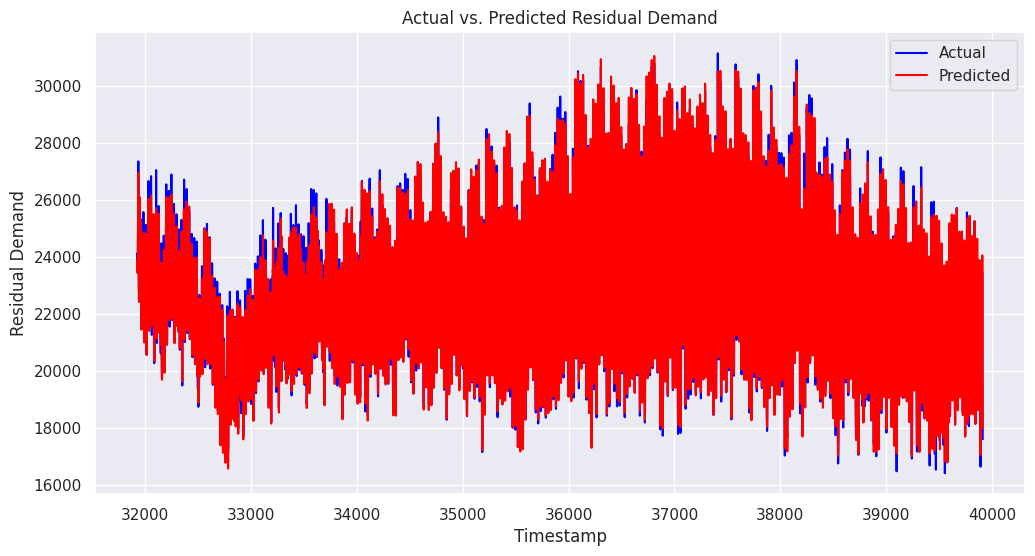

In [9]:
# visualize the evaluation actaul vs predicted
plt.figure(figsize=(12, 6))
plt.plot(yg_val.index, yg_val.values, label='Actual', color='blue')
plt.plot(yg_val.index, pred_g, label='Predicted', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Residual Demand')
plt.title('Actual vs. Predicted Residual Demand')
plt.legend()
plt.show()


In [10]:
# Cell 5 — Synthesize user dataset from grid daily totals

# Aggregate hourly to daily grid totals (daily_consumption)
df_daily_grid = df.set_index('timestamp').resample('D')['residual_demand'].sum().reset_index().rename(columns={'residual_demand':'daily_consumption'})
df_daily_grid = df_daily_grid.sort_values('timestamp').reset_index(drop=True)
print("Grid daily rows:", len(df_daily_grid))
df_daily_grid.head()

# Synthetic user generation parameters
NUM_USERS = 500   # adjust (how many synthetic users to simulate)
START_DATE = df_daily_grid['timestamp'].min()
END_DATE = df_daily_grid['timestamp'].max()
DAYS = len(df_daily_grid)

# We'll distribute each day's total across users by sampling user-specific baseline and day-to-day noise.
np.random.seed(42)
user_baselines = np.random.lognormal(mean=3.0, sigma=0.8, size=NUM_USERS)  # baseline daily consumption scale
user_baselines = user_baselines / user_baselines.sum()  # normalize proportions

# To avoid total mismatch strictly summing to grid, we scale to a fraction of grid each day so users sum to a realistic small portion
USER_SHARE_MEAN = 0.02  # synthetic users collectively represent 2% of grid daily total (adjust)
user_records = []
for idx, row in df_daily_grid.iterrows():
    date = row['timestamp']
    grid_total = float(row['daily_consumption'])
    # daily user pool total = grid_total * fraction (so we simulate users representing part of grid)
    daily_user_pool = max(1.0, grid_total * USER_SHARE_MEAN)
    # per-user expected = baseline * pool * random daily multiplier
    day_multiplier = np.random.normal(loc=1.0, scale=0.05)  # small daily volatility
    per_user_expected = user_baselines * daily_user_pool * day_multiplier
    # add per-user seasonal variation & personal noise
    for u in range(NUM_USERS):
        # seasonal effect: some users consume more on weekends or specific months
        dow = date.weekday()
        weekend_factor = 1.2 if dow >=5 else 1.0
        month = date.month
        month_factor = 1.0 + 0.05 * math.sin(2*math.pi*(month/12.0))  # mild monthly seasonality
        noise = np.random.normal(loc=0.0, scale=0.2)  # multiplicative noise
        user_value = per_user_expected[u] * weekend_factor * month_factor * max(0.1, 1+noise)
        # occasionally drop readings to simulate sparse users (skip ~5% of days)
        if np.random.rand() < 0.05:
            continue
        user_records.append({'user_id': f'user_{u:04d}', 'timestamp': date, 'daily_consumption': float(user_value)})
# Build DataFrame
user_df = pd.DataFrame(user_records)
print("Synthetic user rows:", len(user_df), "unique users:", user_df['user_id'].nunique())
user_df.head()

Grid daily rows: 1663
Synthetic user rows: 789766 unique users: 500


,user_id,timestamp,daily_consumption
0,user_0000,2021-04-01,37.028855
1,user_0001,2021-04-01,16.212626
2,user_0002,2021-04-01,31.006094
3,user_0003,2021-04-01,55.324070
4,user_0004,2021-04-01,13.063183


In [11]:
# Cell 6 — Build 13 features per user and create training table
# Build per-user time series features and stack into a single DataFrame
def build_user_features(df_user):
    df_user = df_user.sort_values('timestamp').reset_index(drop=True)
    df_user['day_of_week'] = df_user['timestamp'].dt.weekday
    df_user['day_of_month'] = df_user['timestamp'].dt.day
    df_user['month'] = df_user['timestamp'].dt.month
    df_user['is_weekend'] = (df_user['day_of_week'] >= 5).astype(int)
    # lags and rolling (shifted)
    for lag in [1,2,7]:
        df_user[f'lag_{lag}'] = df_user['daily_consumption'].shift(lag)
    for w in [3,7,14]:
        df_user[f'rolling_avg_{w}'] = df_user['daily_consumption'].shift(1).rolling(window=w, min_periods=1).mean()
    df_user['rolling_std_7'] = df_user['daily_consumption'].shift(1).rolling(window=7, min_periods=1).std().fillna(0)
    df_user['dow_sin'] = np.sin(2*np.pi*df_user['day_of_week']/7)
    df_user['dow_cos'] = np.cos(2*np.pi*df_user['day_of_week']/7)
    return df_user

# process each user and collect rows that have lag_1 available
list_rows = []
grouped = user_df.groupby('user_id')
for user_id, g in grouped:
    g2 = build_user_features(g)
    g_clean = g2.dropna(subset=['lag_1']).copy()
    if g_clean.empty:
        continue
    # add user id column
    g_clean['user_id'] = user_id
    list_rows.append(g_clean)

if not list_rows:
    raise RuntimeError("No user rows after feature building. Check generation.")

user_feature_df = pd.concat(list_rows, axis=0).reset_index(drop=True)

# Select features & target
feature_cols_user = [
 'day_of_week','day_of_month','month',
 'rolling_avg_3','rolling_avg_7',
 'lag_1','lag_2','lag_7',
 'rolling_avg_14','rolling_std_7',
 'is_weekend','dow_sin','dow_cos'
]
print("User feature df rows:", len(user_feature_df))
X_user = user_feature_df[feature_cols_user].astype(float)
y_user = user_feature_df['daily_consumption'].astype(float)

print("Unique users in train:", user_feature_df['user_id'].nunique())

User feature df rows: 789266
Unique users in train: 500


In [12]:
# Cell 7 — Train user-level LightGBM model
# Sample a subset for speed if dataset is very large
MAX_ROWS = 100000
if len(X_user) > MAX_ROWS:
    sampled_idx = np.random.choice(len(X_user), MAX_ROWS, replace=False)
    X_user_s = X_user.iloc[sampled_idx].reset_index(drop=True)
    y_user_s = y_user.iloc[sampled_idx].reset_index(drop=True)
else:
    X_user_s = X_user.copy()
    y_user_s = y_user.copy()

# time split by date: ensure no future leakage — we'll keep simple random split by index but better to use user/time split for production
split_idx = int(len(X_user_s) * 0.8)
X_train_u, X_val_u = X_user_s.iloc[:split_idx], X_user_s.iloc[split_idx:]
y_train_u, y_val_u = y_user_s.iloc[:split_idx], y_user_s.iloc[split_idx:]
print("User train rows:", len(X_train_u), "val rows:", len(X_val_u))

params_user = {
    'n_estimators': 1200,
    'learning_rate': 0.03,
    'num_leaves': 31,
    'max_depth': 10,
    'min_data_in_leaf': 50,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.2,
    'reg_lambda': 1.0,
    'random_state': 42
}
lgb_user = lgb.LGBMRegressor(**params_user)
lgb_user.fit(X_train_u, y_train_u, eval_set=[(X_val_u, y_val_u)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=50)]) # Use early_stopping callback



User train rows: 80000 val rows: 20000
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 13
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Start training from score 23.614225
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[217]	valid_0's l1: 4.18116	valid_0's l2: 75.7207


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, max_depth=10,
              min_data_in_leaf=50, n_estimators=1200, random_state=42,
              reg_alpha=0.2, reg_lambda=1.0, subsample=0.8)

In [13]:
# evaluate
pred_u = lgb_user.predict(X_val_u)
print("User Val MAE:", mean_absolute_error(y_val_u, pred_u))
print("User Val RMSE:", np.sqrt(mean_squared_error(y_val_u, pred_u))) # Corrected RMSE calculation
print("User Val R2:", r2_score(y_val_u, pred_u))

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
User Val MAE: 4.181163575888545
User Val RMSE: 8.701764201059346
User Val R2: 0.9000996110295341


In [14]:
# Cell 8 — Save models & show feature names
OUT_GRID = "energy_model_eskom_grid.joblib"
OUT_USER = "energy_model_user_13features.joblib"
joblib.dump(lgb_grid, OUT_GRID)
joblib.dump(lgb_user, OUT_USER)
print("Saved:", OUT_GRID, OUT_USER)
print("Grid feature names:", feature_cols_grid)
try:
    print("Grid model.feature_name_:", lgb_grid.feature_name_)
except Exception:
    pass
print("User feature names:", feature_cols_user)
try:
    print("User model.feature_name_:", lgb_user.feature_name_)
except Exception:
    pass

Saved: energy_model_eskom_grid.joblib energy_model_user_13features.joblib
Grid feature names: ['hour', 'weekday', 'lag_1', 'lag_24', 'lag_168', 'roll_mean_3', 'roll_mean_24', 'roll_mean_168']
Grid model.feature_name_: ['hour', 'weekday', 'lag_1', 'lag_24', 'lag_168', 'roll_mean_3', 'roll_mean_24', 'roll_mean_168']
User feature names: ['day_of_week', 'day_of_month', 'month', 'rolling_avg_3', 'rolling_avg_7', 'lag_1', 'lag_2', 'lag_7', 'rolling_avg_14', 'rolling_std_7', 'is_weekend', 'dow_sin', 'dow_cos']
User model.feature_name_: ['day_of_week', 'day_of_month', 'month', 'rolling_avg_3', 'rolling_avg_7', 'lag_1', 'lag_2', 'lag_7', 'rolling_avg_14', 'rolling_std_7', 'is_weekend', 'dow_sin', 'dow_cos']


In [15]:
# Cell 9 — Optional: Download models (Colab) and example upload to Replit
# Download in Colab
try:
    from google.colab import files
    files.download(OUT_GRID)
    files.download(OUT_USER)
except Exception:
    print("Not in Colab env - files are: ", OUT_GRID, OUT_USER)

# Example upload to Replit (adjust REPLIT_URL & API_KEY)
"""
import requests
REPLIT_URL = "https://<your-replit-host>"
API_KEY = "energy-admin-key-2025"
for path in [OUT_GRID, OUT_USER]:
    with open(path, 'rb') as f:
        files_d = {'file': (path, f, 'application/octet-stream')}
        r = requests.post(f"{REPLIT_URL}/model/upload", files=files_d, headers={"x-api-key": API_KEY})
        print("Upload", path, r.status_code, r.text)
        if r.status_code == 200:
            fname = r.json().get('filename')
            act = requests.post(f"{REPLIT_URL}/model/activate", json={"filename": fname}, headers={"x-api-key": API_KEY})
            print("Activated:", act.status_code, act.text)
"""
print("To upload models programmatically, use the commented requests block (fill REPLIT_URL & API_KEY)")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To upload models programmatically, use the commented requests block (fill REPLIT_URL & API_KEY)
